# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import issparse, hstack

# TDA
import kmapper as km
import dyneusr as dsr
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN
from kmapper.cover import Cover
from tmap.tda.utils import optimize_dbscan_eps

In [2]:
# Set seed for reproducibility
seed_value = 27
random.seed(seed_value)

# **2. Import data**

In [4]:
data_path = '/Users/stefanovannoni/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Dottorato/Tesi Magistrale/Data/sMRI_data.csv'

# Load data
data = pd.read_csv(data_path)

# Remove class labels
x = data.drop('study_group', axis=1)

# Class labels
y = data['study_group']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(int)

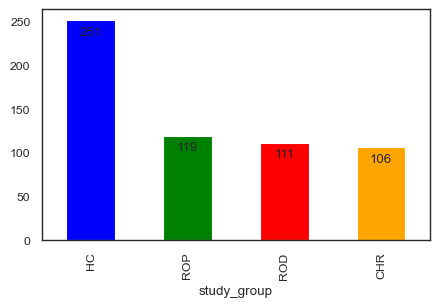

In [5]:
# Class labels histogram
labels_freq = data['study_group'].value_counts()
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(5, 3))
labels_freq.plot(kind='bar', color=colors)

for i, valore in enumerate(labels_freq):
    plt.text(i, valore - 20, str(valore), ha='center', va='bottom')

plt.show()

In [6]:
# Only HC samples
x_hc = data[data['study_group'] == 'HC']
x_hc = x_hc.drop('study_group', axis=1)

# **3. Project data (Filtering)**

In [7]:
# PCA
pca = PCA(n_components=2, random_state=seed_value)
pca = pca.fit(x_hc)

# Isomap
isomap = Isomap(n_components=2)
isomap = isomap.fit(x_hc)

# Kernel PCA
kernelpca = KernelPCA(n_components=2, kernel='rbf', random_state=seed_value)
kernelpca = kernelpca.fit(x_hc)

In [8]:
# Projection into 2D
x_hc_pca = pca.transform(x_hc)
x_hc_isomap = isomap.transform(x_hc)
x_hc_kernelpca = kernelpca.transform(x_hc)

# **4. TDA**

In [9]:
mapper_pca = km.KeplerMapper(verbose=1)
mapper_isomap = km.KeplerMapper(verbose=1)
mapper_kernelpca = km.KeplerMapper(verbose=1)

KeplerMapper()
KeplerMapper()
KeplerMapper()


In [10]:
# Create lens function
lens_pca = mapper_pca.fit_transform(pca.fit_transform(x_hc, y=None), projection=[0,1], scaler=None)
lens_isomap = mapper_isomap.fit_transform(isomap.fit_transform(x_hc, y=None), projection=[0,1], scaler=None)
lens_kernelpca = mapper_kernelpca.fit_transform(kernelpca.fit_transform(x_hc, y=None), projection=[0,1], scaler=None)

# Create cover
cover = Cover(n_cubes=20, perc_overlap=0.5)

# Clusterer
clusterer = DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=5)

..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (251, 2)

..Projecting data using: [0, 1]
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (251, 2)

..Projecting data using: [0, 1]
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (251, 2)

..Projecting data using: [0, 1]


In [11]:
# Create graph
graph_pca = mapper_pca.map(
    lens=lens_pca,
    X=x_hc,
    cover=cover,
    clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
)

graph_isomap = mapper_isomap.map(
    lens=lens_isomap,
    X=x_hc,
    cover=cover,
    clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
)

graph_kernelpca = mapper_kernelpca.map(
    lens=lens_kernelpca,
    X=x_hc,
    cover=cover,
    clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
)

Mapping on data shaped (251, 68) using lens shaped (251, 2)

Creating 400 hypercubes.

Created 291 edges and 114 nodes in 0:00:00.078155.
Mapping on data shaped (251, 68) using lens shaped (251, 2)

Creating 400 hypercubes.

Created 305 edges and 143 nodes in 0:00:00.074529.
Mapping on data shaped (251, 68) using lens shaped (251, 2)

Creating 400 hypercubes.

Created 260 edges and 149 nodes in 0:00:00.088541.


In [12]:
# Convert graphs to networkx
graph_pca_nx = km.adapter.to_nx(graph_pca)
graph_isomap_nx = km.adapter.to_nx(graph_isomap)
graph_kernelpca_nx = km.adapter.to_nx(graph_kernelpca)

In [13]:
# PCA
samples_in_nodes_pca = {name: attributes['membership'] for name, attributes in list(graph_pca_nx.nodes(data=True))}
samples_in_nodes_pca = list(samples_in_nodes_pca.values())
samples_pca = [int(el_pca.split('cube')[1].split('_')[0]) for el_pca in list(graph_pca_nx.nodes())] # node indices (number of nodes of the TDA graph)
print('Number of nodes: ', len(samples_pca))

# Isomap
samples_in_nodes_isomap = {name: attributes['membership'] for name, attributes in list(graph_isomap_nx.nodes(data=True))}
samples_in_nodes_isomap = list(samples_in_nodes_isomap.values())
samples_isomap = [int(el_isomap.split('cube')[1].split('_')[0]) for el_isomap in list(graph_isomap_nx.nodes())] # node indices (number of nodes of the TDA graph)
print('Number of nodes: ', len(samples_isomap))

# Kernel PCA
samples_in_nodes_kernelpca = {name: attributes['membership'] for name, attributes in list(graph_kernelpca_nx.nodes(data=True))}
samples_in_nodes_kernelpca = list(samples_in_nodes_kernelpca.values())
samples_kernelpca = [int(el_kernelpca.split('cube')[1].split('_')[0]) for el_kernelpca in list(graph_kernelpca_nx.nodes())] # node indices (number of nodes of the TDA graph)
print('Number of nodes: ', len(samples_kernelpca))

Number of nodes:  114
Number of nodes:  143
Number of nodes:  149


# **5. Framework validation**

In [14]:
def mapping_tda(data, sample, cover):
    # Add index column to data
    idx = np.arange(data.shape[0])[:, np.newaxis]
    data = np.hstack((idx, data))

    # Fit cover and get cube centers
    bins = cover.fit(data)
    bins = [(sublist[0], sublist[1]) for sublist in bins]

    # Transform data into hypercubes
    hypercubes = cover.transform(data, bins)

    # Find indices of cubes containing the sample
    index_cubes = cover.find(sample)

    # Get indices of matching hypercubes
    hypercubes_index = []
    for index in index_cubes:
        cube = cover.transform_single(data, bins[index])

        for j in range(len(hypercubes)):
            if np.array_equal(cube, hypercubes[j]):
                hypercubes_index.append(j)

    # Print hypercubes with only one sample
    for k in hypercubes_index:
        if len(hypercubes[k]) == 1:
            print(f'Hyper cube {k} with only one sample')
        else:
            continue

    # Return indices, hypercubes, and centers
    return hypercubes_index, hypercubes, bins

## **5.1. PCA filter projection**

In [15]:
# Project HC samples
sample_map_pca = []
check = []

for i in range(len(x_hc)):
    subject = x_hc.iloc[[i]]
    subject_pca = pca.transform(subject)
    hypercubes_index_pca, hypercubes_pca, bins_pca = mapping_tda(x_hc_pca, subject_pca, cover)

    nodes_indices = []
    for k, sample in enumerate(samples_in_nodes_pca):
        if i in sample:
            nodes_indices.append(samples_pca[k])

    if all(index in hypercubes_index_pca for index in nodes_indices):
        check.append(True)

    for cube_index in hypercubes_index_pca:
        if len(hypercubes_pca[cube_index]) > 1:
            if cube_index in samples_pca and f'subject_{i}' not in sample_map_pca:
                sample_map_pca.append(f'subject_{i}')

Hyper cube 135 with only one sample
Hyper cube 2 with only one sample
Hyper cube 3 with only one sample
Hyper cube 2 with only one sample
Hyper cube 3 with only one sample
Hyper cube 148 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 88 with only one sample
Hyper cube 89 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 88 with only one sample
Hyper cube 89 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 88 with only one sample
Hyper cube 89 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 88 with only one sample
Hyper cube 89 with only one sample
Hyper cube 87 with only one sample
Hyper cube 145 with only one sample
Hyper cube 159 with only one sample
Hyper cube 160 with only one sample
Hyper cube 145 with only one sample
Hyper cube 159 with only one sample
Hyper cube 160 wi

In [16]:
np.array(check).sum()

251

In [17]:
miss_indexes = [f'subject_{i}' for i in range(251) if f'subject_{i}' not in sample_map_pca]
miss_indexes = [int(element.split('subject_')[1].split('_')[0]) for element in miss_indexes]

In [18]:
miss_indexes_set = set(miss_indexes)
count = sum(valore in sample for sample in samples_in_nodes_pca for valore in miss_indexes_set)

print(count)

0


## **5.2. Isomap filter projection**

In [19]:
# Project HC samples
isomap_sample_map = []
check = []

for i in range(len(x_hc)):
    subject = x_hc.iloc[[i]]
    subject_isomap = isomap.transform(subject)
    hypercubes_index_isomap, hypercubes_isomap, bins_isomap = mapping_tda(x_hc_isomap, subject_isomap, cover)

    nodes_indices = []
    for k, sample in enumerate(samples_in_nodes_isomap):
        if i in sample:
            nodes_indices.append(samples_isomap[k])

    if all(index in hypercubes_index_isomap for index in nodes_indices):
        check.append(True)

    for cube_index in hypercubes_index_isomap:
        if len(hypercubes_isomap[cube_index]) > 1:
            if cube_index in samples_isomap and f'subject_{i}' not in isomap_sample_map:
                isomap_sample_map.append(f'subject_{i}')

Hyper cube 143 with only one sample
Hyper cube 158 with only one sample
Hyper cube 143 with only one sample
Hyper cube 158 with only one sample
Hyper cube 66 with only one sample
Hyper cube 70 with only one sample
Hyper cube 71 with only one sample
Hyper cube 90 with only one sample
Hyper cube 91 with only one sample
Hyper cube 70 with only one sample
Hyper cube 71 with only one sample
Hyper cube 90 with only one sample
Hyper cube 91 with only one sample
Hyper cube 70 with only one sample
Hyper cube 71 with only one sample
Hyper cube 90 with only one sample
Hyper cube 91 with only one sample
Hyper cube 70 with only one sample
Hyper cube 71 with only one sample
Hyper cube 90 with only one sample
Hyper cube 91 with only one sample
Hyper cube 67 with only one sample
Hyper cube 68 with only one sample
Hyper cube 87 with only one sample
Hyper cube 67 with only one sample
Hyper cube 68 with only one sample
Hyper cube 87 with only one sample
Hyper cube 67 with only one sample
Hyper cube 68 wi

In [20]:
np.array(check).sum()

251

In [21]:
miss_indexes = [f'subject_{i}' for i in range(251) if f'subject_{i}' not in isomap_sample_map]
miss_indexes = [int(element.split('subject_')[1].split('_')[0]) for element in miss_indexes]

In [22]:
miss_indexes_set = set(miss_indexes)
count = sum(valore in sample for sample in samples_in_nodes_isomap for valore in miss_indexes_set)

print(count)

0


## **5.3. KernelPCA filter projection**

In [23]:
# Project HC samples
kernelpca_sample_map = []
check = []

for i in range(len(x_hc)):
    subject = x_hc.iloc[[i]]
    subject_kernelpca = kernelpca.transform(subject)
    hypercubes_index_kernelpca, hypercubes_kernelpca, bins_kernelpca = mapping_tda(x_hc_kernelpca, subject_kernelpca, cover)

    nodes_indices = []
    for k, sample in enumerate(samples_in_nodes_kernelpca):
        if i in sample:
            nodes_indices.append(samples_kernelpca[k])

    if all(index in hypercubes_index_kernelpca for index in nodes_indices):
        check.append(True)

    for cube_index in hypercubes_index_kernelpca:
        if len(hypercubes_kernelpca[cube_index]) > 1:
            if cube_index in samples_kernelpca and f'subject_{i}' not in kernelpca_sample_map:
                kernelpca_sample_map.append(f'subject_{i}')

Hyper cube 54 with only one sample
Hyper cube 159 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 112 with only one sample
Hyper cube 113 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 112 with only one sample
Hyper cube 113 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 112 with only one sample
Hyper cube 113 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 112 with only one sample
Hyper cube 113 with only one sample
Hyper cube 252 with only one sample
Hyper cube 266 with only one sample
Hyper cube 267 with only one sample
Hyper cube 252 with only one sample
Hyper cube 266 with only one sample
Hyper cube 267 with only one sample
Hyper cube 252 with only one sample
Hyper cube 266 with only one sample
Hyper cube 267 with only one sample
Hyper cube 237 with only one sample
H

In [24]:
np.array(check).sum()

251

In [25]:
miss_indexes = [f'subject_{i}' for i in range(251) if f'subject_{i}' not in kernelpca_sample_map]
miss_indexes = [int(element.split('subject_')[1].split('_')[0]) for element in miss_indexes]

In [26]:
miss_indexes_set = set(miss_indexes)
count = sum(valore in sample for sample in samples_in_nodes_kernelpca for valore in miss_indexes_set)

print(count)

0
